In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, Add, Maximum, Average
from keras.layers import Conv2D, Input, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
batch_size = 128
epochs = 10

## Load Data

In [3]:
dir_name = '../../processed_data/expressive_data/'

density = '04'

# load train data

fname = 'x_train_expressive_density_' + density + '.mat'
filename = os.path.join(os.getcwd(),dir_name,fname)
x_train_mat = sio.loadmat(filename)['x_train_expressive_mat']
x_train_mat = np.float32(x_train_mat)

fname = 'y_train_expressive_density_' + density + '.mat'
filename = os.path.join(os.getcwd(),dir_name,fname)
y_train_mat = sio.loadmat(filename)['y_train_expressive_mat']
y_train_mat = np.float32(y_train_mat)

# load test data
fname = 'x_test_expressive_density_' + density + '.mat'
filename = os.path.join(os.getcwd(),dir_name,fname)
x_test_mat = sio.loadmat(filename)['x_test_expressive_mat']
x_test_mat = np.float32(x_test_mat)

fname = 'y_test_expressive_density_' + density + '.mat'
filename = os.path.join(os.getcwd(),dir_name,fname)
y_test_mat = sio.loadmat(filename)['y_test_expressive_mat']
y_test_mat = np.float32(y_test_mat)

print('x_train_shape:',x_train_mat.shape)
print('x_test_shape:',x_test_mat.shape)
print('y_train_shape:',y_train_mat.shape)
print('y_test_shape:',y_test_mat.shape)


# Form training and testing data

x_train = np.zeros((x_train_mat.shape[2],116,116,1),dtype=np.float32)
y_train = np.zeros((x_train_mat.shape[2],1),dtype=np.float32)

x_test = np.zeros((x_test_mat.shape[2],116,116,1),dtype=np.float32)
y_test = np.zeros((x_test_mat.shape[2],1),dtype=np.float32)


for i in range(x_train_mat.shape[2]):
    x_train[i,:,:,0] = x_train_mat[:,:,i]
    y_train[i,0] = y_train_mat[i,0] # EXPRESSIVE SCORE
        
for i in range(x_test_mat.shape[2]):
    x_test[i,:,:,0] = x_test_mat[:,:,i]
    y_test[i,0] = y_test_mat[i,0]  # EXPRESSIVE SCORE

x_train_shape: (116, 116, 17374)
x_test_shape: (116, 116, 8687)
y_train_shape: (17374, 1)
y_test_shape: (8687, 1)


(17374, 116, 116, 1)


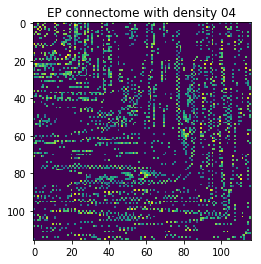

In [4]:
# Reshape input
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
input_shape = (x_train.shape[1], x_train.shape[2], 1)

plt.figure()
plt.imshow(x_train[2,:,:,0])
plt.title('EP connectome with density'+' '+density)
plt.show()

In [23]:
A = np.array([[1,2,3,4],[4,5,6,7],[7,8,9,10],[10,11,12,13]])
print(A)
A = np.triu(A,1)
print(A)

[[ 1  2  3  4]
 [ 4  5  6  7]
 [ 7  8  9 10]
 [10 11 12 13]]
[[ 0  2  3  4]
 [ 0  0  6  7]
 [ 0  0  0 10]
 [ 0  0  0  0]]


In [24]:
for i in range(x_train_mat.shape[2]):
    temp = x_train_mat[:,:,i]
    temp = np.triu(temp,1)
    x_train[i,:,:,0] = temp
    y_train[i,0] = y_train_mat[i,0] # EXPRESSIVE SCORE
        
for i in range(x_test_mat.shape[2]):
    temp = x_test_mat[:,:,i]
    temp = np.triu(temp,1)
    x_test[i,:,:,0] = temp
    y_test[i,0] = y_test_mat[i,0]  # EXPRESSIVE SCORE

(17374, 116, 116, 1)


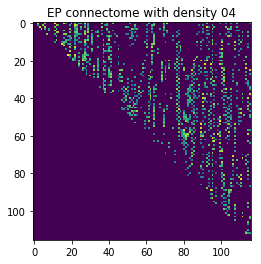

In [25]:
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
input_shape = (x_train.shape[1], x_train.shape[2], 1)

plt.figure()
plt.imshow(x_train[2,:,:,0])
plt.title('EP connectome with density'+' '+density)
plt.show()

## Define RN Model

In [26]:
d_rate = 2

# Define 4 convolutional layers
def ConvolutionNetworks(no_filters=32, kernel_size=3, stride_size=1):
    def conv(model):
        model = Conv2D(no_filters, (3,3), strides=(stride_size,stride_size), activation='relu', input_shape=input_shape, data_format='channels_last')(model)
        model = MaxPooling2D()(model)
        model = BatchNormalization()(model)
        
        model = Conv2D(no_filters, (3,3), strides=(stride_size,stride_size), activation='relu')(model)
        model = MaxPooling2D()(model)
        model = BatchNormalization()(model)
        
        model = Conv2D(no_filters, (3,3), strides=(stride_size,stride_size), dilation_rate=(d_rate,d_rate), activation='relu')(model)
        model = MaxPooling2D()(model)
        model = BatchNormalization()(model)
        
        model = Conv2D(no_filters, (3,3), strides=(stride_size,stride_size), dilation_rate=(d_rate,d_rate), activation='relu')(model) # d=3
        #model = Conv2D(16, (3,3), strides=(stride_size,stride_size), activation='relu')(model) # d=4
        model = MaxPooling2D()(model)
        model = BatchNormalization()(model)
        
        return model
    return conv

In [42]:
# Define function to compute relations from objects - the following uses just 4 Lambda layers - O(n^2) time complexity

def compute_relations(objects):
    
    def get_top_dim_1(t):
        return t[:,0,:,:]
    
    def get_all_but_top_dim_1(t):
        return t[:,1:,:,:]
    
    def get_top_dim_2(t):
        return t[:,0,:]
    
    def get_all_but_top_dim_2(t):
        return t[:,1:,:]
    
    slice_top_dim_1 = Lambda(get_top_dim_1)
    slice_all_but_top_dim_1 = Lambda(get_all_but_top_dim_1)
    slice_top_dim_2 = Lambda(get_top_dim_2)
    slice_all_but_top_dim_2 = Lambda(get_all_but_top_dim_2)
    
    d = K.int_shape(objects)[2]
    print('d = ', d)
    features = []
    
    for i in range(d):
        features1 = slice_top_dim_1(objects)
        objects = slice_all_but_top_dim_1(objects)
        
        for j in range(d):
            features2 = slice_top_dim_2(features1)
            features1 = slice_all_but_top_dim_2(features1)
            features.append(features2)
            
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            #if (features.index(feature1) < features.index(feature2)):
            relations.append(concat([feature1,feature2]))
                    
            
    return relations


In [43]:
# Baseline model
def f_theta():
    def f(model):
        model = Dense(512)(model)
        model = Activation('relu')(model)
        model = Dropout(0.5)(model)
        
        model = Dense(512)(model)
        model = Activation('relu')(model)
        model = Dropout(0.5)(model)
        
        model = Dense(512)(model)
        model = Activation('relu')(model)
        
        #model = Dense(100)(model)
        #model = Activation('relu')(model)
        
        return model
    return f


In [44]:
# Define the Relation Networks

def g_th(layers):
    def f(model):
        for n in range(len(layers)):
            model = layers[n](model)
        return model
    return f

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f

def g_theta(units=512, layers=4):
    r = []
    for k in range(layers):
        r.append(Dense(units))
        r.append(Activation('relu'))
    return g_th(r)

def get_MLP():
    return g_th()

In [45]:
# Define the main RN
    
def RelationNetworks(objects):
    g_t = g_theta()
    relations = compute_relations(objects)
    print('No of Relations:', len(relations))
    #print(relations)
    
    g_all = []
    
    for i, r in enumerate(relations):
        g_all.append(g_t(r))
        
    # combine to make the network combinatorially generalizable
    #combined_relation = Add()(g_all)
    #combined_relation = Maximum()(g_all)
    combined_relation = Average()(g_all) # works best when combining relations
    
    f_out = f_theta()(combined_relation)
    return f_out

In [46]:

input_img = Input((x_train.shape[1], x_train.shape[2], 1))  
img_after_conv = ConvolutionNetworks()(input_img) 
#tag = build_tag(img_after_conv)
#img_after_conv = Concatenate()([tag, img_after_conv])

img_after_RN = RelationNetworks(img_after_conv)

img_out = Dense(1, activation='linear')(img_after_RN)

#RN_model = Model(inputs=[input_img, tag], outputs=img_out)
RN_model = Model(inputs=[input_img], outputs=img_out)


d =  3
No of Relations: 81


In [47]:
#compile model
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

RN_model.compile(optimizer=adam, loss='mse', metrics=['mae','mape'])

In [48]:
# Train Model
RN_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/10
17374/17374 [==============================] - 21s 1ms/step - loss: 0.0478 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 24.3860
Epoch 2/10
17374/17374 [==============================] - 10s 592us/step - loss: 0.0071 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 9.6639
Epoch 3/10
17374/17374 [==============================] - 10s 591us/step - loss: 0.0057 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 8.5869
Epoch 4/10
17374/17374 [==============================] - 10s 590us/step - loss: 0.0046 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 7.6760
Epoch 5/10
17374/17374 [==============================] - 10s 589us/step - loss: 0.0040 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 7.1178
Epoch 6/10
17374/17374 [==============================] - 10s 591us/step - loss: 0.0033 - mean_absolute_error: 0.0440 - mean_absolute_percentage_error: 6.4662
Epoch 7/10
17374/17374 [=======================

In [49]:
# Save the trained Model weights
save_weights_name = 'upper_triang_RN_model_expressive_weights_density_' + density + '.h5'
RN_model.save_weights(save_weights_name)

# Save the model architecture
save_arch_name = 'upper_triang_RN_model_expressive_arch_density_' + density + '.json'
with open(save_arch_name,'w') as f:
    f.write(RN_model.to_json())

In [50]:
# Test Model
y_test_pred = RN_model.predict(x_test)


In [51]:
print(y_test.shape)
print('y_test:', y_test)


print(y_test_pred.shape)
print('y_test_pred:', y_test_pred)


# Print Results
print('mae: ', np.mean(np.abs(y_test - y_test_pred)))
print('sdae: ', np.std(np.abs(y_test - y_test_pred)))

(8687, 1)
y_test: [[0.425     ]
 [0.7416667 ]
 [0.7583333 ]
 ...
 [0.4998589 ]
 [0.49373698]
 [0.5045685 ]]
(8687, 1)
y_test_pred: [[0.40460193]
 [0.5835743 ]
 [0.57740766]
 ...
 [0.44443816]
 [0.436697  ]
 [0.45225173]]
mae:  0.13352531
sdae:  0.07238157


In [52]:
count = 0
for i in range(len(y_test)):
    if (np.abs(y_test[i] - y_test_pred[i])) < 0.125: # prob of mae less than 15 - 15/120 = 0.125
        count += 1
        
prob_error = count / len(y_test)

print('prob of mae less than 0.125: ', prob_error)

prob of mae less than 0.125:  0.43352135374697826
